In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import fft, fftfreq, ifft

In [2]:
class Simulator:
    
    kb = 1.308064e-23 # Boltzmann constant
    
    def __init__(self):
        pass
    
    def configure_experiment(self, 
                             lambda_lazer = 650e-9,
                             temperature = 273.15,
                             theta = np.pi / 3,
                             n = 1.33,
                             eta = 0.958e-3):
        
        self.lambda_lazer = lambda_lazer
        self.temperature = temperature
        self.theta = theta
        self.n = n
        self.eta = eta
        
        #Evaluate coefficient
        self.coeff = 2*(Simulator.kb * self.temperature/(3 * np.pi * self.eta)) * (4 * np.pi * self.n / self.lambda_lazer)**2 * np.sin(self.theta / 2)**2
    
    
    def get_lorentz(self, diameter, freq):
        if diameter == 0:
            raise ValueError('zero passed as a diameter')
        
        G = self.coeff / diameter
        
        # QUESTION: Do we really need (1 / pi) here?
        return 1 / np.pi * G / ((2 * np.pi * freq)**2 + G**2)
    

    def generate(self,
                 particle_diameters = np.array([100e-9]),
                 noise_level = 0.0,
                 time_series_size = 2**10,
                 f_s = 8000,
                 num_frequencies = 2**19 + 1):
        
        frequencies = np.linspace(0, f_s / 2, num_frequencies)
        
        initial_phases = np.random.uniform(0, 2 * np.pi, num_frequencies)
        
        time_series = np.linspace(0, time_series_size, time_series_size * f_s)
        
        ideal_lorentz = self.get_lorentz(particle_diameters[0], frequencies)
        amplitudes = np.sqrt(ideal_lorentz)
        
        get_x_ti = lambda t: sum(amplitudes * np.sin(2 * np.pi * frequencies * t))
        x_t = np.array(list(map(get_x_ti, time_series)))
        
        intensities = x_t**2
        
        return (intensities, time_series)
        
    

    def run_simulation(self, 
                       particle_diameters = np.array([38e-9]),
                       noise_level = 0.0,
                       time_series_size = 2**10,
                       f_generation = 50,
                       max_freq_value = 5514.0,
                       num_frequencies = 2**12):
        
        # x(t_i) = SUM_k^n [ sqrt(S(f_k)) * sin(2pi * f_k * t_i + phi_k)} ]
        
        # Generate @num_frequencies random frequencies uniformly distributed in the range [0, @max_freq_value]
        random_frequencies = np.random.uniform(0, max_freq_value, num_frequencies)
        
        # Generate @num_frequencies random initial phases (phi_k) uniformly distributed in the range [0, 2pi]
        initial_phases = np.random.uniform(0, 2 * np.pi, num_frequencies)
        
        # Create @time_series_size consecutive time values 0, 1, 2, ... , @time_series_size - 1
        
        time_series = np.linspace(0, time_series_size, time_series_size * f_generation)
        
        
        # Ideal lorentz S(f) = S[d1](f) + ... + S[dN](f)
        # Get an ideal amplitude SQRT(S(f)) for each random frequency (f_k) so as to obtain all SQRT[S(f_k)]
        ideal_lorentz = sum([self.get_lorentz(d, random_frequencies) for d in particle_diameters])
        ideal_amplitudes = np.sqrt(ideal_lorentz)
        
        
        # Obtain x(time_series)
        get_x_ti = lambda t: sum(ideal_amplitudes * np.sin(2 * np.pi * random_frequencies * t + initial_phases))
        x_t = np.array(list(map(get_x_ti, time_series)))
        
        # Do normalization {x(t) - min(x(t))} so as to have positive (ala-experimental) values (refer to the article)
        min_x_t = min(x_t)
        x_t = x_t - min_x_t # FIXME: Due to peculiarity of calculations in CPU some values can be negative 
                            # (even though it has not happened yet)
                            # By the fact, we get squares of these numbers for the final result
        
        
        # Get experimental intesities: light intensity ~ (x_t)**2
        experimental_intensities = x_t

        
        return (experimental_intensities, time_series)
        
                                                     
                                                     
                                                     
    
    

In [3]:
%matplotlib inline

simulator = Simulator()
simulator.configure_experiment()

intensities, time_series = simulator.generate()


fig, ax = plt.subplots()
ax.plot(time_series, intensities, label='Signal')
plt.legend()

KeyboardInterrupt: 

In [ ]:
%matplotlib inline

freqs = np.linspace(0, 6000, 2**14 + 1)
ideal_lorentz = np.array(simulator.get_lorentz(100e-9, freqs))
ideal_amplitudes = np.sqrt(ideal_lorentz)

fig, ax = plt.subplots()
ax.plot(freqs, ideal_lorentz, label='Lorentz')
ax.plot(freqs, ideal_amplitudes, label='Squared root')
plt.legend()

In [ ]:
%matplotlib inline

N = len(time_series)

yf = fft(intensities)
freqs = fftfreq(len(intensities), d=1/12000)

fig, ax = plt.subplots()
ax.plot(freqs[np.where(freqs >= 0)], 2.0/N * np.abs(yf[0:(len(yf) + 1)//2]), 'o', label='furier')
plt.legend()

In [ ]:
%matplotlib inline

N = 400
f_s = 200
time_series = np.linspace(0, N, N * f_s)
signal = 2 * np.sin(2 * np.pi * 60 * time_series)

yf = fft(signal)
freqs = fftfreq(len(signal), d=1/f_s)

fig, ax = plt.subplots()
ax.plot(freqs[np.where(freqs >= 0)], 2.0/N/f_s * np.abs(yf[0:(len(yf) + 1)//2]), label='furier')
plt.legend()

# %matplotlib inline

y = intensities[0:200]


yf = fft(y) + fft(intensities[200:400] + fft(intensities[400:600]))
freqs = fftfreq(len(y), d=1/12000)

fig, ax = plt.subplots()
ax.plot(freqs[np.where(freqs >= 0)], np.abs(yf[0:(len(yf) + 1)//2]), label='Furier transform')
plt.legend()

# WRIM

In [6]:
# import libraries to determine coeffs
import sklearn.linear_model as sklm
import scipy

# define scaling and wavelet basis functions
wavelet_func = lambda t: 1 if t > 0 and t < 0.5 else (-1 if t > 0.5 and t < 1 else 0)
scaling_func = lambda t: 1 if t > 0 and t < 1 else 0

# get new time series according to m and k
def get_new_time_series(time_series, m, k):
    a0 = 2
    return (a0**-m) * time_series - k

# calculate coeff for wavelet part with fixed m and k
def scaling_coeff(time_series, intensities, wavelet_func, m, k):
    coeff = 0 # needed coeff 
    a0 = 2 # from article
    
    # create new time series according to article:
    new_time_series = get_new_time_series(time_series, m, k)
    
    # calculate coeff
    for i in range(len(time_series)):
        coeff += intensities[i] * scaling_func(new_time_series[i]) * (a0**(-m/2))
    return coeff
    
 # example
print(scaling_coeff(time_series, intensities, scaling_func, 2, 0))

# calculate wavelet part of a signal decomposition with fixed m and k
def scaling_part(time_series, intensities, scaling_func, m, k):
    i = 0
    while i < m:
        # calculate coeff for wavelet part
        coeff = scaling_coeff(time_series, intensities, wavelet_func, i, k)
        # calculate new time series for the next step
        time_series = get_new_time_series(time_series, i, k)
        # now intensities is wavelet part from the last step
        #print(intensities)
        for j in range(len(intensities)):
            intensities[j] = coeff * scaling_func(time_series[j])
        i += 1
        
    return intensities

0.0002583128718761886


/home/alex/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:153: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[index]
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


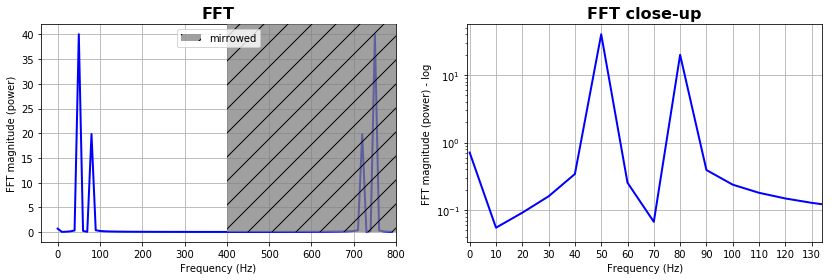

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

fig = plt.figure(figsize=[14,4])
N = 600           # Number of samplepoints
Fs = 800.0
T = 1.0 / Fs      # N_samps*T (#samples x sample period) is the sample spacing.
N_fft = 80        # Number of bins (chooses granularity)
x = np.linspace(0, N*T, N)     # the interval
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)   # the signal

# removing the mean of the signal
mean_removed = np.ones_like(y)*np.mean(y)
y = y - mean_removed

# Compute the fft.
yf = scipy.fftpack.fft(y,n=N_fft)
xf = np.arange(0,Fs,Fs/N_fft)

##### Plot the fft #####
ax = plt.subplot(121)
pt, = ax.plot(xf,np.abs(yf), lw=2.0, c='b')
p = plt.Rectangle((Fs/2, 0), Fs/2, ax.get_ylim()[1], facecolor="grey", fill=True, alpha=0.75, hatch="/", zorder=3)
ax.add_patch(p)
ax.set_xlim((ax.get_xlim()[0],Fs))
ax.set_title('FFT', fontsize= 16, fontweight="bold")
ax.set_ylabel('FFT magnitude (power)')
ax.set_xlabel('Frequency (Hz)')
plt.legend((p,), ('mirrowed',))
ax.grid()

##### Close up on the graph of fft#######
# This is the same histogram above, but truncated at the max frequence + an offset. 
offset = 1    # just to help the visualization. Nothing important.
ax2 = fig.add_subplot(122)
ax2.plot(xf,np.abs(yf), lw=2.0, c='b')
ax2.set_xticks(xf)
ax2.set_xlim(-1,int(Fs/6)+offset)
ax2.set_title('FFT close-up', fontsize= 16, fontweight="bold")
ax2.set_ylabel('FFT magnitude (power) - log')
ax2.set_xlabel('Frequency (Hz)')
ax2.hold(True)
ax2.grid()

plt.yscale('log')

In [8]:
import pywt
import numpy as np
import seaborn
from statsmodels.robust import mad
 
def wrim(signal, level=0, wavelet='db4'):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    
    experimental_lorentz = fft(y)
    freqs = fftfreq(len(y))
    return y, experimental_lorentz, freqs
    



In [9]:
res, y, x = wrim(intensities, level=5)

/home/alex/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:153: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[index]


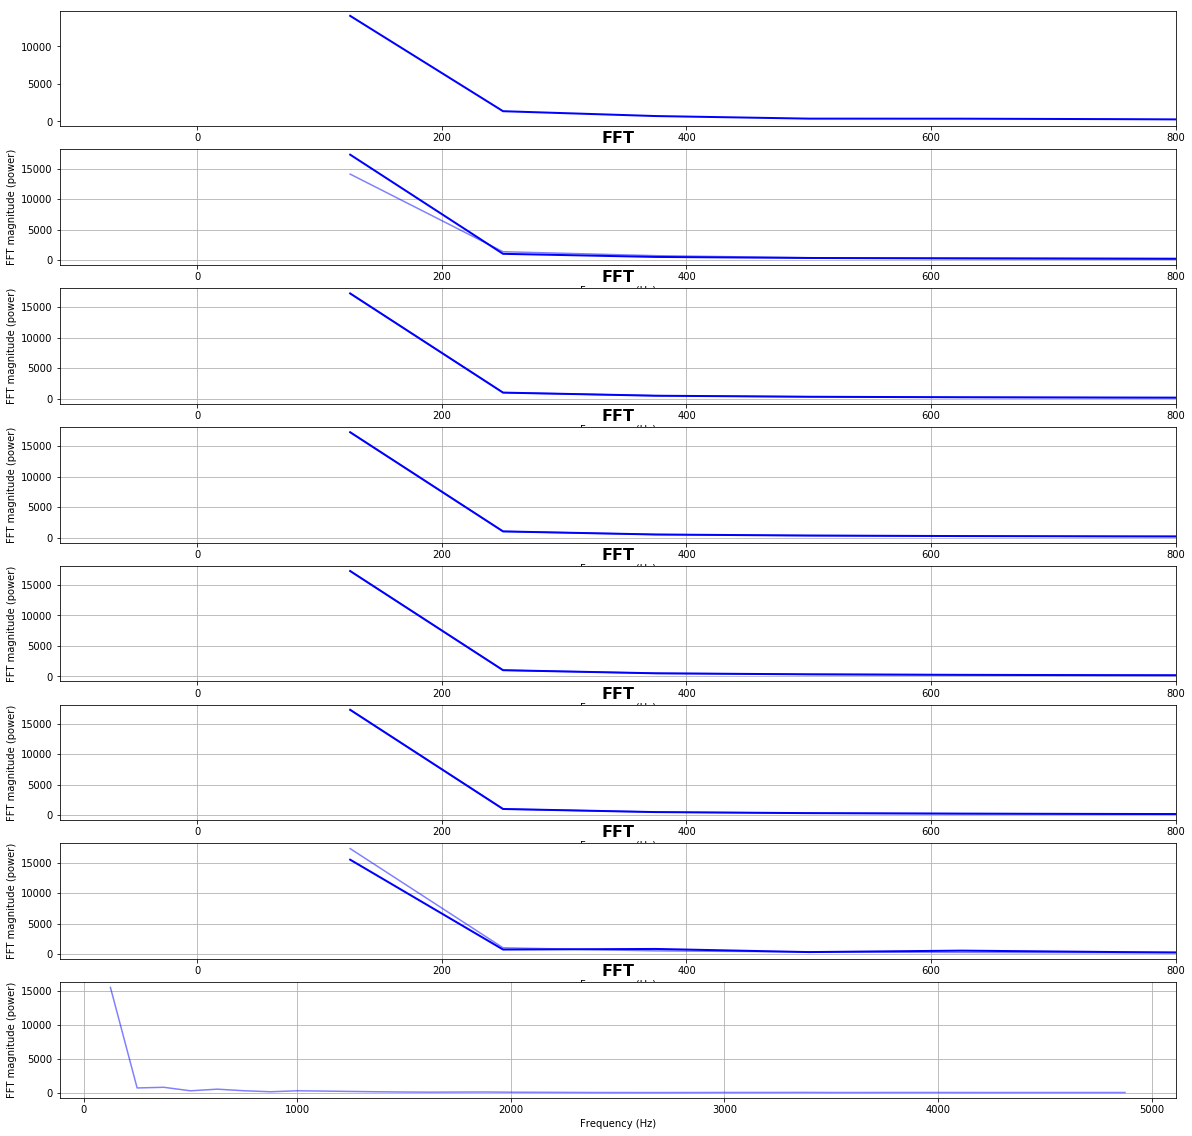

In [31]:
m = 6 # decomposition level
i = 0 
y = intensities
x = time_series
f, ax = plt.subplots(8, figsize=(20,20))
while i <= m:
    y, lorenthz, freqs = wrim(y, i)
    mean_removed = np.ones_like(y)*np.mean(y)
    y = y - mean_removed
    # Compute the fft.
    yf = scipy.fftpack.fft(y,n=N_fft)
    xf = fftfreq(len(yf)) * 10000
    xf = [x for x in xf if x > 0]
    pt = ax[i].plot(xf, abs(yf[:39]), lw=2.0, c='b')
    ax[i].set_xlim((ax[i].get_xlim()[0],Fs))
    i += 1
    ax[i].plot( xf, abs(yf[:39]), color="b", alpha=0.5 )
    ax[i].set_title('FFT', fontsize= 16, fontweight="bold")
    ax[i].set_ylabel('FFT magnitude (power)')
    ax[i].set_xlabel('Frequency (Hz)')
    ax[i].grid()

/home/alex/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


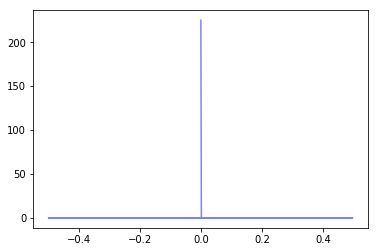

In [10]:
f, ax = plt.subplots()
ax.plot( x, y, color="b", alpha=0.5 )

In [11]:
y = res
x = time_series
mean_removed = np.ones_like(y)*np.mean(y)
y = y - mean_removed

# Compute the fft.
yf = scipy.fftpack.fft(y,n=N_fft)
xf = fftfreq(len(yf)) * 10000

/home/alex/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:153: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[index]


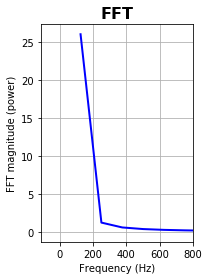

In [12]:
##### Plot the fft #####
ax = plt.subplot(121)
xf = [x for x in xf if x > 0]
pt, = ax.plot(xf, abs(yf[:39]), lw=2.0, c='b')
ax.set_xlim((ax.get_xlim()[0],Fs))
ax.set_title('FFT', fontsize= 16, fontweight="bold")
ax.set_ylabel('FFT magnitude (power)')
ax.set_xlabel('Frequency (Hz)')
ax.grid()

In [13]:
coeff = simulator.coeff
# диапазон размеров частиц, где ищем нужный размер 
d_min = 1e-9 # 1 нм
d_max = 1e-4 

# задаем сетку по Gamma
G_min = coeff/d_max
G_max = coeff/d_min
N = 256*8 # Число узлов в сетке по \Gamma
M = len(xf) # Число точек по частоте
p = (G_max/G_min)**(1/(N-1))
G = np.zeros(N)

# неравнмерная сетка со сгущением к нулю (так как больщий вклад в интенсивность дают крупные частицы)
# хотя такая сетка - это не единственно возможный вариант
for j in range(N):
    G[j] = G_min * (p**j)

# вот равномерная сетка
#G = np.linspace(G_min, G_max, N)    

A = np.zeros((M,N))

# Матрица коэффициентов (составляется по базисным ф-ям)
for i in range(M):
    for j in range(N):
        A[i,j] = G[j] / ((2 * np.pi * xf[i])**2 + G[j]**2)  

/home/alex/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(1.0, 100000.0)

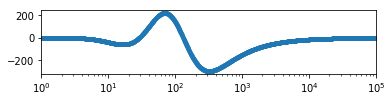

In [14]:
# Три метода решения переопределенной системы: Тихоновская регуляризация, неотрицательная Тихоновская регялризация и метод Лассо
# Ridge regression
clf = sklm.Ridge(alpha = 5e-7)
clf.fit(A, yf[:39])
a1 = clf.coef_

fig = plt.figure()
ax = plt.subplot(3,1,1)
line, = plt.plot(1e+9 * coeff/G, a1,'.-')
ax.set_xscale('log')
plt.xlim(d_min*1e9, d_max*1e9)

In [33]:
sequence = ['Google', 'Vk', 'gdgf']

In [34]:
sequence[0:2]

['Google', 'Vk']

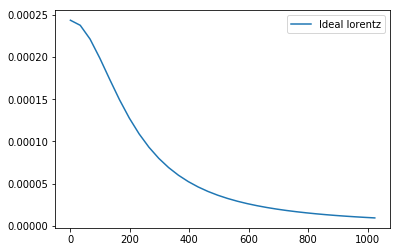

In [88]:
%matplotlib inline

simulator = Simulator()
simulator.configure_experiment()

N_f = 2**5
f_max = 2**10

x = np.linspace(0, f_max, N_f)
y = simulator.get_lorentz(100e-9, x)

fig, ax = plt.subplots()
ax.plot(x, y, label='Ideal lorentz')
plt.legend()

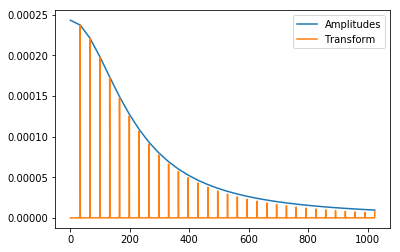

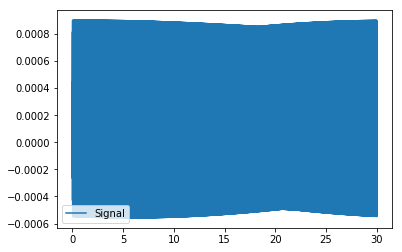

In [89]:
%matplotlib inline

f_s = 2*f_max
time_size = 30

s_freqs = np.linspace(0, f_max, N_f)
s_amplitudes = simulator.get_lorentz(100e-9, s_freqs)

fig, ax = plt.subplots()
ax.plot(s_freqs, s_amplitudes, label='Amplitudes')
plt.legend()

time_series = np.linspace(0, time_size, f_s * time_size)
initial_phases = np.random.uniform(0, 2 * np.pi, N_f)

x_t = np.array(list(map(lambda t:sum(s_amplitudes * np.sin(2 * np.pi * s_freqs * t + initial_phases)), time_series)))

fig1, ax1 = plt.subplots()
ax1.plot(time_series, x_t, label='Signal')
plt.legend()

yf = fft(x_t)
xf = fftfreq(len(x_t), d=1/f_s)


ax.plot(xf[np.where(xf > 0)], 2.0 / len(time_series) * np.abs(yf[1:(len(yf)+ 1) //2]), markersize=1, label='Transform')
ax.legend()